In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd

In [2]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
 
  def grad_sigmoid(self, x):
    return x*(1-x) 
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)           
    yl=yl[yl!=0]                     
    yl=-np.log(yl)                    
    yl=np.mean(yl)
    return yl

   
  def get_accuracy(self,Y_pred,y_actual):    
    acc={}     
    for i in range(Y_pred.shape[0]):
      acc[i]=(np.where(Y_pred[i]==np.amax(Y_pred[i]))[0].item())
     
        
    acc=np.array(list(acc.values()))
    acc=acc+1
    ans=(np.sum(np.equal(acc,y_actual))/len(y_actual))
    return ans

 
    
            
     
 
  def grad(self, x, y):    
    self.forward_pass(x) 
    self.dW = {}   
    self.dB = {}   
    self.dH = {}        
    self.dA = {}  
    L = self.nh + 1
      
    self.dA[L] = (self.H[L] - y)   
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])                     
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)             
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
    
        
    
  def fit(self, X, Y, y_actual , learning_rate=0.01, epochs=100, initialize='True', display_loss=False):
      
    if display_loss:
      loss = {}
      acc = {}   
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    for epoch in range(epochs):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
        
     
      for x, y in zip(X, Y):
        self.grad(x, y)         
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]    
          dB[i+1] += self.dB[i+1]
                  
      m = X.shape[1]  
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (dW[i+1]/m) 
        self.B[i+1] -= learning_rate * (dB[i+1]/m)
     
    
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
        acc[epoch]=self.get_accuracy(Y_pred,y_actual)
    
    if display_loss:
      fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,5))
      ax1.plot(list(loss.values()))
      ax1.set(xlabel='Epochs',ylabel='Error')
      ax2.plot(list(acc.values()))
      ax2.set(xlabel='Epochs',ylabel='Accuracy')
      plt.show()
      print("Error Train:",loss[epoch])
      print("Accuracy Train:",acc[epoch]*100)

In [3]:
data = pd.read_csv('dataset_NN.csv')

In [4]:
data.head()

,att1,att2,att3,att4,att5,att6,class
0,1.0,0.0,0.0,133.150861,1.311693,1620.221779,1
1,1.0,0.0,0.0,126.724861,1.302745,1609.334822,1
2,1.0,0.0,0.0,131.173861,1.319031,1568.978435,1
3,1.0,0.0,0.0,129.478861,1.270878,1695.055281,1
4,1.0,0.0,0.0,127.262861,1.329637,1647.720235,1


In [5]:
def process(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    X = (X-X.mean(axis= 0)) / X.std(axis= 0)

    return X, y

In [6]:
X, y = process(data)

In [7]:
def split_train_test(X, y, split, seed):

    
    rows = int(X.shape[0] * split)
    indices = np.arange(X.shape[0])
    np.random.seed(seed)
    np.random.shuffle(indices)
    train = indices[:rows]
    test = indices[rows:]

    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    return X_train, y_train, X_test, y_test

In [8]:
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.7, 23)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()
print(y_train)

[10  5  6 ...  6  7  3]


In [9]:


y_OH_train = np.zeros((X_train.shape[0], len(y.unique()-1)))
for i in range(X_train.shape[0]):
    y_OH_train[i, y_train[i]-1] = 1    
print(y_OH_train)

y_OH_test = np.zeros((X_test.shape[0], len(y.unique())))
for i in range(X_test.shape[1]):
    y_OH_test[i, y_test[i]-1] = 1

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


2 hidden layers


---------------------------------------------------------------------------
                            Learning Rate:  0.1

Train


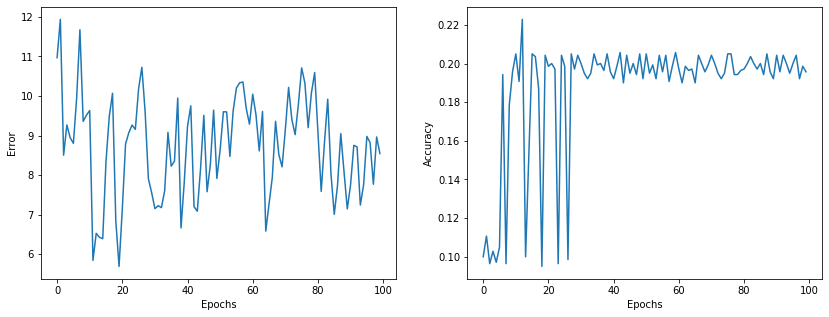

Error Train: 8.544686163953102
Accuracy Train: 19.57142857142857

Test
Error Test:  9.598874590848999
Accuracy Test:  21.0

---------------------------------------------------------------------------
                            Learning Rate:  0.01

Train


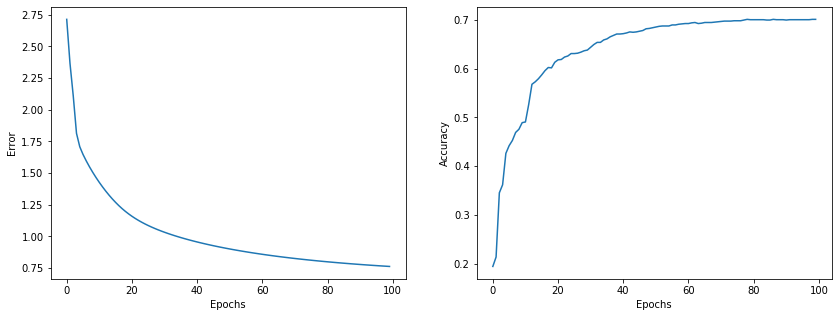

Error Train: 0.7634828306600859
Accuracy Train: 70.07142857142857

Test
Error Test:  1.1809554603301715
Accuracy Test:  69.33333333333334

---------------------------------------------------------------------------
                            Learning Rate:  0.001

Train


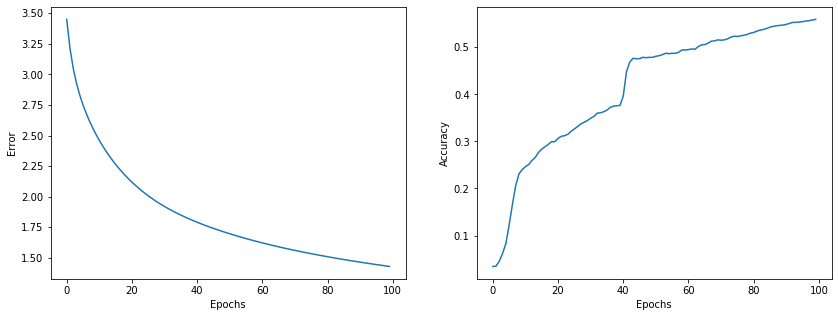

Error Train: 1.4295162444348755
Accuracy Train: 55.92857142857143

Test
Error Test:  1.3207658461310487
Accuracy Test:  56.99999999999999


In [10]:
# For 2 hidden layers
print("2 hidden layers\n")
lr=[0.1,0.01,0.001]                 #0.1 keeps oscillating around minima   #0.001 doesnt get to reach minima

for i in lr:
    print("\n---------------------------------------------------------------------------")
    print("                            Learning Rate: ",i)
    print("\nTrain")
    nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [X_train.shape[1]+6,X_train.shape[1]+6])
    nn.fit(X_train, y_OH_train,y_train, learning_rate=i , display_loss= True)
    
    print("\nTest")
    predictions = nn.predict(X_test)
    error=nn.cross_entropy(predictions, y_OH_test)
    print("Error Test: ",error)
    acc=nn.get_accuracy(predictions,y_test)
    print("Accuracy Test: ",acc*100)

1 hidden layer


---------------------------------------------------------------------------
Learning Rate:  0.1

Train


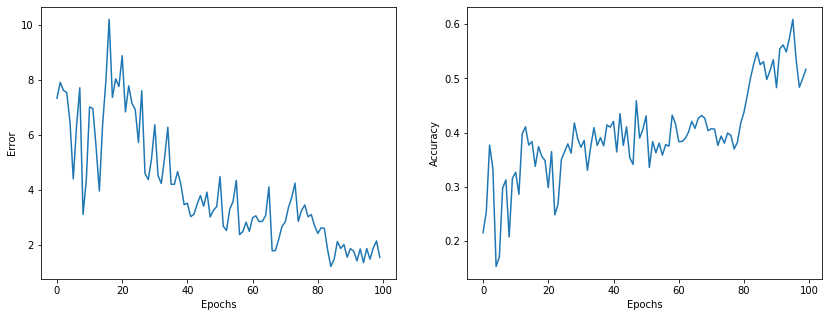

Error Train: 1.53531169476299
Accuracy Train: 51.642857142857146

Test
Error Test:  2.519998698578328
Accuracy Test:  52.166666666666664

---------------------------------------------------------------------------
Learning Rate:  0.01

Train


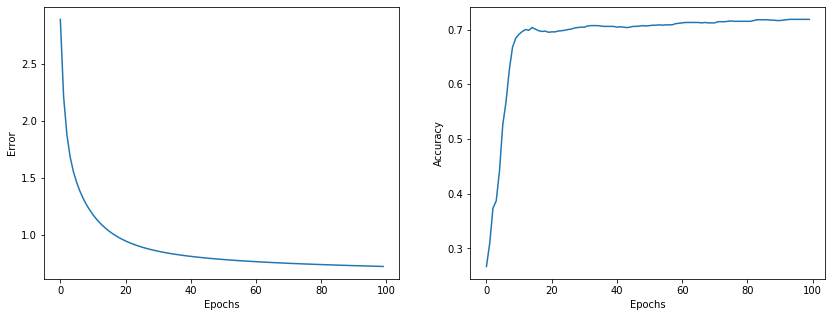

Error Train: 0.7230761089936623
Accuracy Train: 71.85714285714285

Test
Error Test:  0.7735111306076737
Accuracy Test:  70.0

---------------------------------------------------------------------------
Learning Rate:  0.001

Train


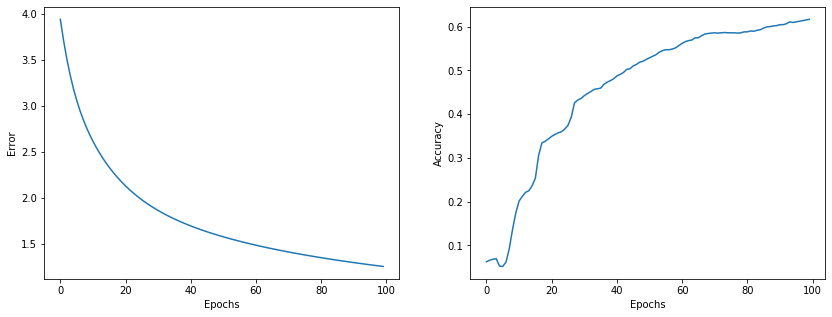

Error Train: 1.2554560256434915
Accuracy Train: 61.642857142857146

Test
Error Test:  1.189007018125891
Accuracy Test:  60.83333333333333


In [11]:
# For 1 hidden layer
print("1 hidden layer\n")
lr=[0.1,0.01,0.001]

for i in lr:
    print("\n---------------------------------------------------------------------------")
    print("Learning Rate: ",i)
    print("\nTrain")
    nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [X_train.shape[1]+6])
    nn.fit(X_train, y_OH_train,y_train, learning_rate=i , display_loss= True)
    
    print("\nTest")
    predictions = nn.predict(X_test)
    error=nn.cross_entropy(predictions, y_OH_test)
    print("Error Test: ",error)
    acc=nn.get_accuracy(predictions,y_test)
    print("Accuracy Test: ",acc*100)